# Dynamical Friction Analysis of a Perturber within a Plummer Sphere Distribution

**AUTHOR: LORENZO ZANGA**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
import pandas as pd
import astropy
import astropy.units as u
from tqdm import tqdm
import os
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import pandas as pd
import seaborn as sns
import scipy.integrate as integrate
import glob
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

**INITIALIZATION OF THE DISTRIBUTION [INTERNAL UNITS]**

In [2]:
N = 4000
a = 1
M = 1
m = M/N*np.ones(N) 
G = 1
M_BH=0.03*M
M_tot = M_BH + m[1]*(N-1)
m[0] =  M_BH

$$
\rho(r)=\frac{M_{TOT}}{\frac{4}{3}\pi r^3}\frac{1}{(1+\frac{r^2}{a^2})^\frac{5}{2}}
$$

In [3]:
def rho(r):
    return 3*M_tot/(4*np.pi*a**3) *1/( (1+r**2/a**2)**(5/2))

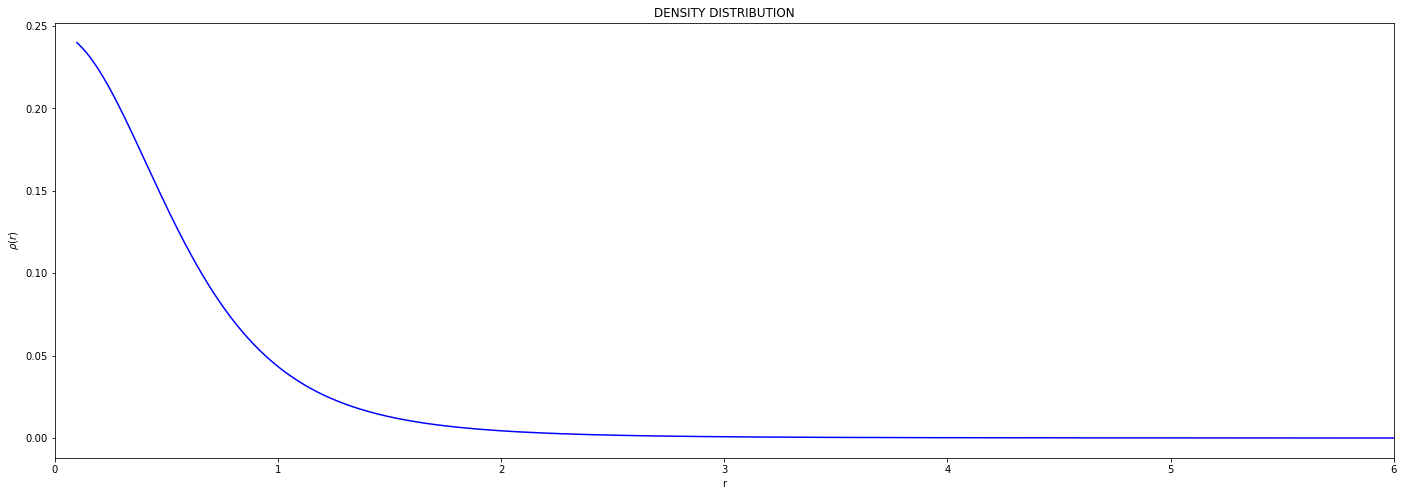

In [4]:
radii= np.linspace(0.1, 10*a, N)
rho_ = rho(radii)
fig,ax = plt.subplots(figsize=(24,8))
ax.set_xlim(0, 6*a)
ax.set_title(r'DENSITY DISTRIBUTION')
ax.set_xlabel('r')
ax.set_ylabel(r'$\rho(r)$')
ax.plot(radii, rho_,color='blue')


In [5]:
#distribuzione radiale
np.random.seed(42)
P_r = np.random.uniform(0,1,N) # uniform distribution within [0,1]
Radius = a*np.sqrt(P_r**(2/3)/(1-P_r**(2/3))) # sample R(P) 

#distribuzione angolare
P_theta = np.random.uniform(0,1,N) 
Theta = np.arccos(1-2*P_theta) #produce una distribuzione uniforme di punti su una sfera

#distribuzione azimutale
P_phi = np.random.uniform(0,2*np.pi,N) #uniform from 0 to 2pi
Phi = P_phi


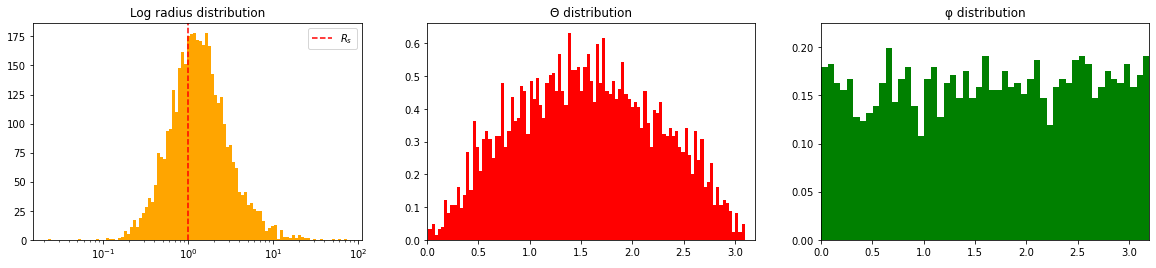

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))

axes[0].hist(Radius, bins=np.logspace(np.log10(np.min(Radius)), np.log10(np.max(Radius)), 100), color='orange')
axes[0].axvline(x=a, linestyle='--', color='red', label=r'$R_s$')
axes[0].set_title('Log radius distribution')
axes[0].set_xscale('log')
axes[0].legend()

axes[1].hist(Theta, bins=100, density=True, color='red')
axes[1].set_title("Θ distribution")
axes[1].set_xlim(0,3.2)

axes[2].hist(Phi, bins=100, density=True, color='green')
axes[2].set_title("φ distribution")
axes[2].set_xlim(0,3.2);

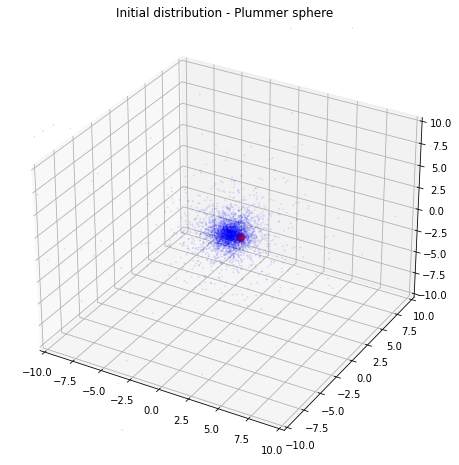

In [11]:
#Il codice trasforma le coordinate sferiche in coordinate cartesiane e visualizza la distribuzione tridimensionale dei punti. Inoltre, calcola il centro di massa del sistema e regola i limiti degli assi in base a quest'ultimo.

x = np.array(Radius * np.sin(Theta) * np.cos(Phi))
y = np.array(Radius * np.sin(Theta) * np.sin(Phi))
z = np.array(Radius * np.cos(Theta))
x[0]=0.8*a
y[0]=0
z[0]=0
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z, s=1, alpha = 0.08, c = 'blue')
ax.scatter(x[0], y[0], z[0], c = 'red', s= 0.5*M_BH/m[1], alpha=1)
ax.set_title('Initial distribution - Plummer sphere')
#ax.set_xlabel(r'x [pc]')
#ax.set_ylabel(r'y [pc]')
#ax.set_zlabel(r'z [pc]')
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-10,10);

 **VERIFICO CHE LA DENSITà A VARI RAGGI CORRISPONDA CON LE PREVISIONI TEORICHE**

In [12]:
def n_particles(r_grid, r_distrib): # Function to get the number of particles inside each shell (at a fixed time)
    n_part = []
    r_plot = []
    for i in range(len(r_grid) - 1):
        left = r_grid[i]
        right = r_grid[i + 1]
        provv = np.sum((r_distrib > left) & (r_distrib < right))
        
        if provv != 0:
            n_part.append(provv)
            r_plot.append(right)
        
    return n_part, r_plot

In [13]:
r_grid   = np.linspace(min(Radius),max(Radius),1000)
r_sort = np.sort(Radius)

In [14]:
# Compute the density profile of the sampled distribution
n_part, r_plot = n_particles(r_grid,r_sort)
r_plot = np.array(r_plot)
V = np.array([4*np.pi*r_plot[i+1]**3/3 - 4*np.pi*r_plot[i]**3/3 for i in range(len(r_plot)-1)])
density = n_part[1:]/V*m[1]
err_density = np.sqrt(n_part[1:])*m[1]/V

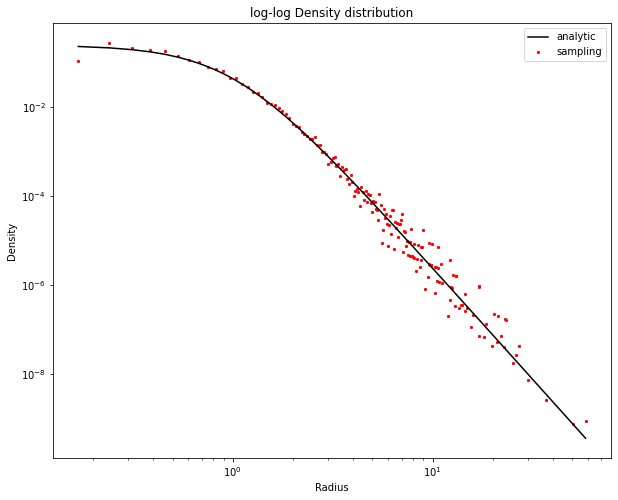

In [15]:
fig = plt.figure(figsize=(10,8))

#theoretical distribution
plt.plot(r_plot[1:],rho(r_plot[1:]), label='analytic', zorder=10,color='black')

plt.scatter(r_plot[1:], density, s=5, zorder=1, label='sampling',color='red', marker='x')
plt.xlabel('Radius')
plt.ylabel('Density')
plt.loglog()
plt.legend()
plt.title('log-log Density distribution')

plt.show()

 **INIZIALIZZO LE VELOCITÀ**

The velocity distribution is isotropic. For bound orbits $\vert \vec{v} \vert = q \sqrt{\Psi}$, where  $\Psi\left(\vec{x}\right) = -\phi\left(\vec{x}\right)$,  $q$ is a position indipendent random number distributed with 
$$
 f(q) = A q^2 \left(1-q^2\right)
$$

and $\phi$ is the potential of the Plummer sphere:

$$\phi=\frac{-GM_{tot}}{\sqrt{r^2+b^2}}$$


The relative potential is:
$$\psi=-\phi+\phi_0=-\phi$$

We setted $\phi_0$ as zero.
- Compute the normalization constant
- sample q with the Montecarlo rejection method
- Compute the magnitude of the velocities.  $\vert \vec{v} \vert = q \sqrt{\Psi}$
Since the distribution is isotropic, it should form a sphere in velocity space.



$$
\begin{cases}
   \vert \vec{v} \vert = q \sqrt{\Psi} &&  0 \le q \le 1  && \text{with $f(q)$} \\ \\
    v_{\varphi} = \tilde{\varphi} && 0 \le \tilde{\varphi} \le 2 \pi \\ \\
    v_{\theta} = \arccos(1-2 \omega) &&  0 \le \omega \le 1 
\end{cases}
$$


To switch to Cartesian coordinates, I use the following change of coordinates.

$$
\begin{cases}
   v_{x} = \vert \vec{v} \vert \cos(v_{\varphi}) \sin(v_{\theta}) \\
   v_{y} = \vert \vec{v} \vert \sin(v_{\varphi}) \sin(v_{\theta}) \\
   v_{z} = \vert \vec{v} \vert  \cos(v_{\theta})
\end{cases}
$$

The potential in the plummer sphere is given by

$$\Phi = -\frac{GM}{(a^2+r^2)^{1/2}}$$

In [16]:
def phi(r):
    
    return -1 * M_tot/ (a**2 + r**2)**(1/2)

In [17]:
Phi = phi(Radius)
Psi=-Phi

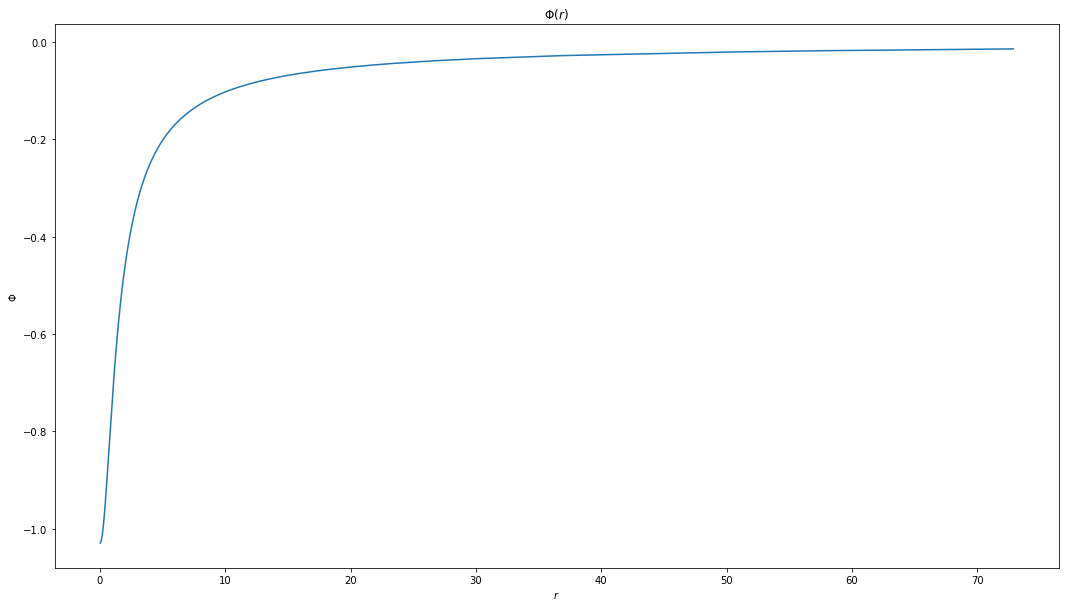

In [18]:
fig,ax = plt.subplots(figsize=(18,10))
#ax.set_xlim(0, 6*a)
ax.set_title(r"$\Phi(r)$")
ax.set_xlabel(r"$r$")
ax.set_ylabel("$\Phi$")
ax.plot(Radius[np.argsort(Radius)], Phi[np.argsort(Radius)])


### Escape velocity

$$v_{es} = \sqrt{2\psi}$$

In [19]:
v_escape = (2 * (-1 * Phi))**(1/2)

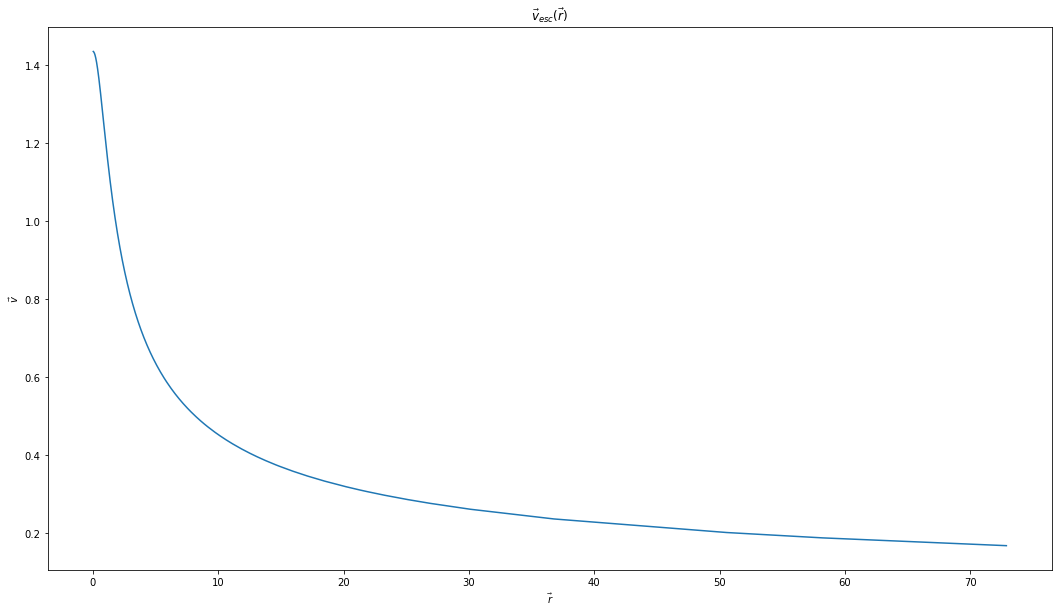

In [20]:
fig,ax = plt.subplots(figsize=(18,10))
ax.set_title(r"$\vec{v}_{esc}(\vec{r})$")
ax.set_xlabel(r"$\vec{r}$")
ax.set_ylabel(r"$\vec{v}$")
ax.plot(Radius[np.argsort(Radius)], v_escape[np.argsort(Radius)])

In [21]:
def f_q(q):
    return (1-q**2)**(7/2) * q**2

**MONTE CARLO REJECTION METHOD**

In [22]:
# Il codice utilizza il metodo di rifiuto Monte Carlo (MC rejection method) per campionare valori da una distribuzione definita dalla funzione 
q_grid = np.linspace(0,1,N)
pdf_test = lambda x: (x**2*(1-x**2)**(7/2))
A = integrate.quad(pdf_test,0,1)
q_ = [] #lista per memorizzare i valori accettati di q
fq = [] #Lista per memorizzare i valori accettati della funzione f_q

#Il loop continua fino a quando non si hanno N valori accettati
while(len(q_)<N):
    q = np.random.uniform(0,1) # sample q between 0 and 1
    f = f_q(q) # compute the upper limit for the distribution
    y_val = np.random.uniform(0,0.092) # sample y between 0 and the maximum of the function
    if(y_val<f):
        q_.append(q) # accept q
        fq.append(1/A[0]*y_val) # accept y

[Text(0.5, 1.0, 'q sampling with MC rejection method'), Text(0.5, 0, '$q$')]

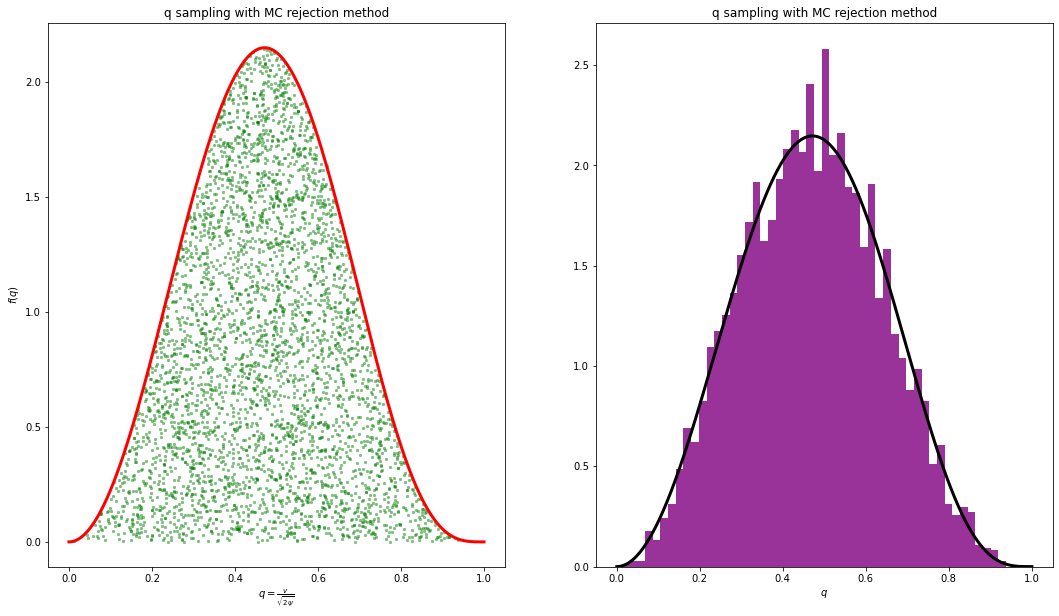

In [23]:
th_pdf=1/A[0]*(q_grid**2*(1-q_grid**2)**(3.5))
fig,ax = plt.subplots(1,2,figsize=(18,10))
ax[0].scatter (q_,fq,s=5,label='MC rejection', color='green', marker='x', alpha=0.5)
ax[0].plot(q_grid, 1/A[0]*f_q(q_grid), color='red', lw=3, label=r'$f(q)=(1-q^2)^{7/2}q^2$' ) # plot the theoretical expectations
ax[0].set(title='q sampling with MC rejection method', xlabel=r'$q=\frac{v}{\sqrt{2\psi}}$', ylabel=r'$f(q)$')
ax[1].hist(q_, bins=50, color='purple', alpha=0.8, density=True);
ax[1].plot(q_grid, th_pdf, color='black', lw=3, label=r'$f(q)=(1-q^2)^{7/2}q^2$' ) 
ax[1].set(title='q sampling with MC rejection method', xlabel=r'$q$')
#plt[0].xlabel(r'$q=\frac{v}{\sqrt{2\psi}}$')
#plt.ylabel(r'$f(q)$')
#plt.legend();

In [24]:
v = q_ * np.sqrt(2 * Psi)



v_theta_cdf = np.random.uniform(0,1,N)
v_theta = np.arccos(1 - 2 * v_theta_cdf)
v_phi = np.random.uniform(0, 2 * np.pi, size=N)

In [25]:
v[0]=0#BH

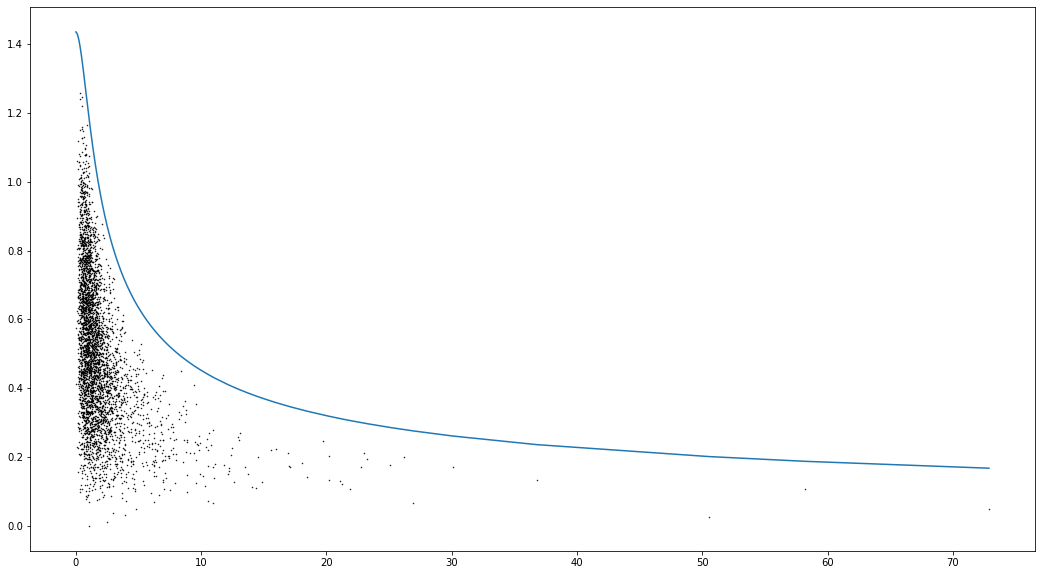

In [26]:
fig,ax = plt.subplots(1,1,figsize=(18,10))
ax.scatter(Radius, v, marker='.', s=1, color='black', label='Velocities')
ax.plot(Radius[np.argsort(Radius)], v_escape[np.argsort(Radius)])
#plt.yscale('log')

In [27]:
v_x = v * np.cos(v_phi) * np.sin(v_theta)
v_y = v * np.sin(v_phi) * np.sin(v_theta)
v_z = v * np.cos(v_theta)

In [28]:
#v perturber
v_x[0]=-0.3
v_y[0]=0.3

In [29]:
np.sqrt(0.5**2*2)

0.7071067811865476

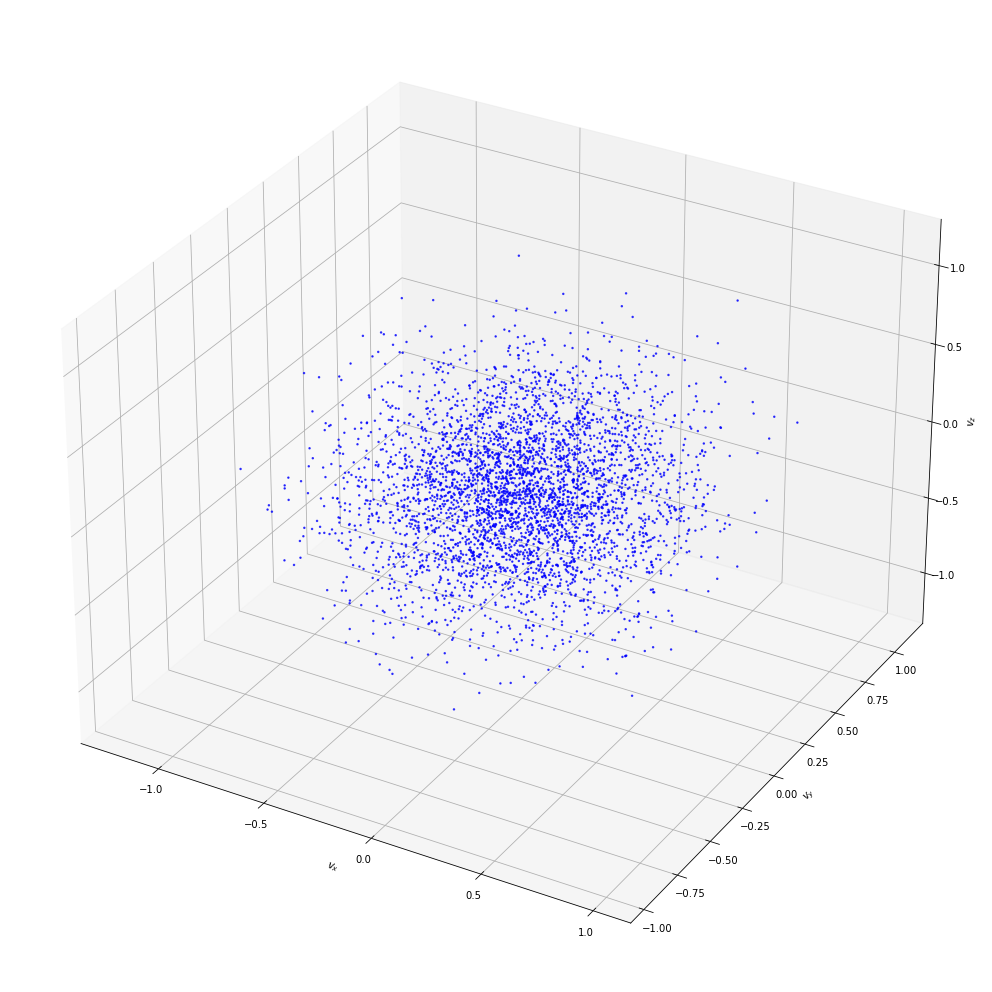

In [30]:
fig = plt.figure(figsize = (18,18))
ax = fig.add_subplot(projection='3d')
ax.scatter(v_x, v_y, v_z, c = 'blue', s=8.5, alpha = 0.7, marker='.')
ax.label='velocity distribution'
ax.set_aspect('auto')
ax.set_xlabel(r'$v_x$')
ax.set_ylabel(r'$v_y$')
ax.set_zlabel(r'$v_z$')
plt.show();

# Creation of initial condition File

In [31]:
# creating the input file
m_array = m 
dim = 3


with open ('in_data.txt', 'w+') as f:
    f.write(str(N) + '\n')
    f.write(f'{dim}' + '\n')
    f.write('0' + '\n')
    for m_i in m_array:
        f.write(f'{m_i}' + '\n')
    for i in range(N):
        f.write(f'{x[i]} {y[i]} {z[i]}' + '\n')
    for j in range(N):
        f.write(f'{v_x[j]} {v_y[j]} {v_z[j]}' + '\n')

In [32]:
mask = Radius<a
V = 4/3 * np.pi * a**3
density = np.sum(m_array[mask])/ V
#epsilon = 1/100 * (V/N)**(1/3)
T = np.sqrt(3 * np.pi/ (16* G * density) )
print(T*20)

52.57941679339123


In [33]:
T_sim = 10 * T
print('Simulation time:', T_sim)

dt = 0.02*T #poi metti diviso 16
print('Time step:', dt)

theta = 0.2
print('Theta:', theta)

t_out = dt
print('Terminal out:', t_out)

Simulation time: 26.289708396695616
Time step: 0.05257941679339123
Theta: 0.2
Terminal out: 0.05257941679339123


# simulazione

In [34]:
import os

open('outdata.txt', 'w').close()

os.system('time ./treecode in=in_data.txt  dtime='+ str(dt) +' theta='+str(theta)+ ' tstop='+str(T_sim) +' dtout='+str(t_out)+' out=output_file.txt')




Hierarchical N-body code (theta scan)

   nbody     dtime       eps     theta   usequad     dtout     tstop
    4000   0.05258    0.0250      0.20     false   0.05258   26.2897

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   3.024    5084   7768553   2254563   0.004

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       0.000 0.16532 0.15396 0.31928 0.48222 0.01917 0.01162   0.004

	data output to file output_file.txt at time 0.000000

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      14   3.011    5073   7766854   2253368   0.003

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       0.053 0.16534 0.15412 0.31947 0.48244 0.01917 0.01162   0.007

	data output to file output_file.txt at time 0.052579

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   2.972    5097   7663772   2314956   0.003

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jto

       2.629 0.16506 0.16615 0.33120 0.50165 0.01917 0.01162   0.209

	data output to file output_file.txt at time 2.628970

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   2.997    5139   7757554   2248367   0.004

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       2.682 0.16502 0.16636 0.33138 0.50202 0.01917 0.01162   0.214

	data output to file output_file.txt at time 2.681550

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   2.978    5149   7796734   2223112   0.004

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       2.734 0.16487 0.16649 0.33137 0.50245 0.01917 0.01162   0.218

	data output to file output_file.txt at time 2.734129

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      14   3.006    5143   7831783   2198277   0.004

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       2.787 0.16490 0.16648 0.33138 0.5023

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      12   3.047    5134   7859880   2175300   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       5.363 0.16453 0.17306 0.33759 0.51264 0.01917 0.01161   0.496

	data output to file output_file.txt at time 5.363100

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   3.035    5158   7918007   2154150   0.005

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       5.416 0.16450 0.17270 0.33720 0.51217 0.01917 0.01161   0.501

	data output to file output_file.txt at time 5.415679

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      14   3.053    5146   7973469   2130221   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       5.468 0.16449 0.17249 0.33698 0.51186 0.01917 0.01161   0.507

	data output to file output_file.txt at time 5.468258

	   rsize  tdepth   ftree  actmax    nbbtot

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       8.045 0.16366 0.16243 0.32609 0.49812 0.01917 0.01161   0.752

	data output to file output_file.txt at time 8.044649

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   3.055    5127   7888939   2199870   0.004

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       8.097 0.16365 0.16235 0.32600 0.49801 0.01917 0.01161   0.757

	data output to file output_file.txt at time 8.097229

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   3.023    5104   7835396   2238254   0.005

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       8.150 0.16382 0.16215 0.32597 0.49745 0.01917 0.01161   0.762

	data output to file output_file.txt at time 8.149809

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   3.026    5120   7847497   2228073   0.004

        time   |T+U|       T      -U    -T/

	data output to file output_file.txt at time 10.726223

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   3.006    5145   7793548   2213072   0.005

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      10.779 0.16283 0.16373 0.32655 0.50138 0.01917 0.01161   1.024

	data output to file output_file.txt at time 10.778803

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      12   3.010    5139   7776387   2232138   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      10.831 0.16286 0.16386 0.32672 0.50154 0.01917 0.01161   1.030

	data output to file output_file.txt at time 10.831383

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   3.013    5132   7804186   2203924   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      10.884 0.16269 0.16390 0.32660 0.50185 0.01917 0.01161   1.036

	data output to file output_file.txt at 

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      12   3.080    5144   7972704   2113406   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      13.460 0.16172 0.16031 0.32204 0.49781 0.01917 0.01161   1.286

	data output to file output_file.txt at time 13.460377

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   3.084    5165   8001627   2119741   0.007

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      13.513 0.16172 0.16011 0.32183 0.49749 0.01917 0.01161   1.293

	data output to file output_file.txt at time 13.512957

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      12   3.049    5168   7908335   2171369   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      13.566 0.16174 0.15993 0.32167 0.49718 0.01917 0.01161   1.299

	data output to file output_file.txt at time 13.565536

	   rsize  tdepth   ftree  actmax    nbb

	   128.0      14   3.036    5102   7891946   2196310   0.005

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      16.142 0.16093 0.15675 0.31768 0.49342 0.01916 0.01161   1.569

	data output to file output_file.txt at time 16.141951

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   3.067    5092   7948290   2164226   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      16.195 0.16103 0.15675 0.31778 0.49327 0.01916 0.01161   1.576

	data output to file output_file.txt at time 16.194530

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   3.034    5105   7915188   2174810   0.005

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      16.247 0.16102 0.15682 0.31784 0.49340 0.01916 0.01161   1.581

	data output to file output_file.txt at time 16.247110

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   3.051    5088   7920

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      18.824 0.16043 0.16482 0.32525 0.50674 0.01916 0.01161   1.866

	data output to file output_file.txt at time 18.823524

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      14   2.989    5178   7771247   2223263   0.004

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      18.876 0.16043 0.16488 0.32532 0.50684 0.01917 0.01161   1.871

	data output to file output_file.txt at time 18.876104

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      12   3.014    5163   7808848   2207188   0.007

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      18.929 0.16044 0.16498 0.32542 0.50698 0.01917 0.01161   1.879

	data output to file output_file.txt at time 18.928684

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   2.990    5175   7832903   2202087   0.006

        time   |T+U|       T      -U    

      21.505 0.15935 0.16194 0.32129 0.50403 0.01916 0.01161   2.132

	data output to file output_file.txt at time 21.505098

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      15   3.014    5132   7849425   2195818   0.004

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      21.558 0.15937 0.16179 0.32116 0.50377 0.01916 0.01161   2.137

	data output to file output_file.txt at time 21.557678

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   2.996    5115   7791842   2225970   0.004

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      21.610 0.15936 0.16174 0.32110 0.50371 0.01916 0.01161   2.141

	data output to file output_file.txt at time 21.610258

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   3.008    5133   7800129   2232932   0.004

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      21.663 0.15935 0.16176 0.32110 0.5

	data output to file output_file.txt at time 24.186672

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      13   3.004    5139   7845083   2216482   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      24.239 0.15918 0.16248 0.32166 0.50514 0.01917 0.01161   2.408

	data output to file output_file.txt at time 24.239252

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      12   3.032    5108   7911968   2164042   0.005

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      24.292 0.15918 0.16251 0.32169 0.50517 0.01917 0.01161   2.413

	data output to file output_file.txt at time 24.291832

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   128.0      14   2.997    5120   7775579   2226740   0.005

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      24.344 0.15922 0.16246 0.32168 0.50504 0.01917 0.01161   2.419

	data output to file output_file.txt at 


real	1m39.651s
user	1m34.696s
sys	0m2.622s


0

# Lettura file

In [35]:
file_name = "output_file.txt"
print(file_name)

output_file.txt


In [36]:
file = open(file_name, 'r') #apri il file in modalità lettura

N_part = int(file.readline()) # read the first line where is written the number of particles

dim = file.readline() # read the second line
t_0 = file.readline() # read the third line where is written the initial time
file.seek(0) # go back to the beginning of the file

N_lines = 0
N_lines = sum(1 for _ in open(file_name)) # Calcola il numero di righe nel file

print('N_part : ', N_part)
print('dim : ', dim)
print('initial time : ', t_0)
print('N_lines: ', N_lines)

file.close()

N_part :  4000
dim :   3

initial time :    0.0000000E+00

N_lines:  6013503


In [37]:
N_lines_snap = 3+N_part*3 # righe per ogni snap
N_snap = N_lines / N_lines_snap # determine the number of snapshots

print('N snapshot: ', N_snap)

N snapshot:  501.0


In [38]:
# Questo codice legge le informazioni relative alle istantanee dal file "output_file.txt" e le organizza in array per le posizioni, le velocità, i tempi e le masse delle particelle.

N_cols = 3

# define the time array:
t_sim = np.zeros(int(N_snap))

# define the masses array
masses = np.empty([int(N_snap),N_part]) 

# create arrays for the positions: each snapshot, each particle
x_sim = np.empty([int(N_snap), N_part])
y_sim = np.empty([int(N_snap), N_part])
z_sim = np.empty([int(N_snap), N_part])

positions = np.empty([int(N_snap), N_part, int(dim)])

# create arrays for the velocities: each snapshot, each particle
Vx_sim = np.empty([int(N_snap), N_part])
Vy_sim = np.empty([int(N_snap), N_part])
Vz_sim = np.empty([int(N_snap), N_part])

velocities = np.empty([int(N_snap), N_part, int(dim)])

for i in tqdm(range(int(N_snap))): # iterate on the snapshots
    time_line = i*N_lines_snap + 2 # starting line for time
    mass_line = time_line + 1 # starting line for masses
    posit_line = mass_line + N_part # starting line for postions
    vel_line = posit_line + N_part # starting line for velocities
    
    #Utilizzando la funzione genfromtxt() di NumPy, vengono letti i dati per ogni istantanea dal file "output_file.txt" e vengono memorizzati negli array corrispondenti.
    t_sim[i] = np.genfromtxt(file_name, skip_header=time_line, max_rows=1) # fill the time array
    
    masses[i] = np.genfromtxt(file_name, skip_header=mass_line, max_rows=N_part) # read masses
    positions[i] = np.genfromtxt(file_name, skip_header=posit_line, max_rows=N_part) # read positions
    velocities[i] = np.genfromtxt(file_name, skip_header=vel_line, max_rows=N_part) # read velocities
    
# fill the coordinates vector
x_sim = positions[:,:,0]
y_sim = positions[:,:,1]
z_sim = positions[:,:,2]

# compute the radial positions
r_sim = np.sqrt(x_sim**2 + y_sim**2 + z_sim**2)

# fill the velocities coordinate vector
Vx_sim = velocities[:,:,0]
Vy_sim = velocities[:,:,1]
Vz_sim = velocities[:,:,2]

# compute the radial velocities
Vr_sim = np.sqrt(Vx_sim**2 + Vy_sim**2 + Vz_sim**2)

100%|█████████████████████████████████████████| 501/501 [13:58<00:00,  1.67s/it]


In [39]:
r_sim = np.sqrt(x_sim**2 + y_sim**2 + z_sim**2)

In [40]:
#particelle
x_s = x_sim[1: : , :]
y_s = y_sim[1: : , :]
z_s = z_sim[1: : , :]

vx_s = Vx_sim[1: : , :]
vy_s = Vy_sim[1: : , :]
vz_s = Vz_sim[1: : , :]

In [41]:
r_s = r_sim[1: : , :]

In [42]:
xp_s = x_sim[:, 0]
yp_s = y_sim[:, 0]
zp_s = z_sim[:, 0]

vpx_s = Vx_sim[:, 0]
vpy_s = Vy_sim[:, 0]
vpz_s = Vz_sim[:, 0]

In [43]:
rp_s = r_sim[:, 0]

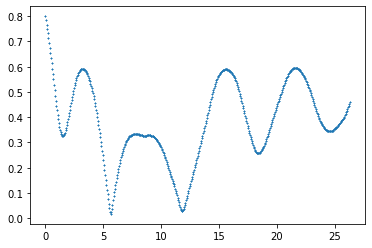

In [44]:
plt.scatter(t_sim,rp_s, marker='x',s=1)

In [57]:
from mpl_toolkits.mplot3d import Axes3D
import imageio
import os

In [58]:
if not os.path.exists('frames'):
    os.makedirs('frames')


l=5
for i, t in tqdm(enumerate(t_sim), total=len(t_sim), desc="Generazione dei frame"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Colorare il primo punto di ogni vettore
    ax.scatter(x_sim[i][0], y_sim[i][0], z_sim[i][0], c='red',s= 0.5*M_BH/m[1], alpha=1, label='Perturber')
    ax.scatter(x_sim[i][1:], y_sim[i][1:], z_sim[i][1:], c='blue',s=1, alpha = 0.1)
    
    ax.set_xlim([-l, l])
    ax.set_ylim([-l, l])
    ax.set_zlim([-l, l])
    ax.set_title(f'Time: {t:.2f}')
    if i == 0:
        ax.legend()
        
    plt.savefig(f'frames/frame_{i:03d}.png')
    plt.close()

with imageio.get_writer('particles_simulation.gif', mode='I', duration=0.01) as writer:
    for i in tqdm(range(len(t_sim)), desc="Creazione della GIF"):
        image = imageio.imread(f'frames/frame_{i:03d}.png')
        writer.append_data(image)

for i in range(len(t_sim)):
    os.remove(f'frames/frame_{i:03d}.png')
os.rmdir('frames')

print("GIF creata con successo!")

In [59]:
l=5*a
for i, t in tqdm(enumerate(t_sim), total=len(t_sim), desc="Generazione dei frame"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Colorare il primo punto di ogni vettore
    ax.scatter(x_sim[i][0], y_sim[i][0], z_sim[i][0], c='red', s=0.2 * M_BH / m[1], alpha=1, label='Perturber')
    ax.scatter(x_sim[i][1:], y_sim[i][1:], z_sim[i][1:], c='blue', s=1, alpha=0.02)
    
    ax.set_xlim([-l, l])
    ax.set_ylim([-l, l])
    ax.set_zlim([-l, l])
    ax.set_title(f'Time: {t:.2f}')
    if i == 0:
        ax.legend()
        
    plt.savefig(f'frames/frame_{i:03d}.png')
    plt.close()


Generazione dei frame: 100%|██████████████████| 501/501 [02:41<00:00,  3.11it/s]


In [60]:
with imageio.get_writer('particles_simulation.gif', mode='I', duration=0.02) as writer:
    for i in tqdm(range(len(t_sim)), desc="Creazione della GIF"):
        image = imageio.imread(f'frames/frame_{i:03d}.png')
        writer.append_data(image)

# Puliamo la cartella temporanea
for i in range(len(t_sim)):
    os.remove(f'frames/frame_{i:03d}.png')
os.rmdir('frames')

print("GIF creata con successo!")

Creazione della GIF: 100%|████████████████████| 501/501 [00:11<00:00, 42.25it/s]


GIF creata con successo!


Text(0.5, 1.0, 'Plummer Centre of Mass')

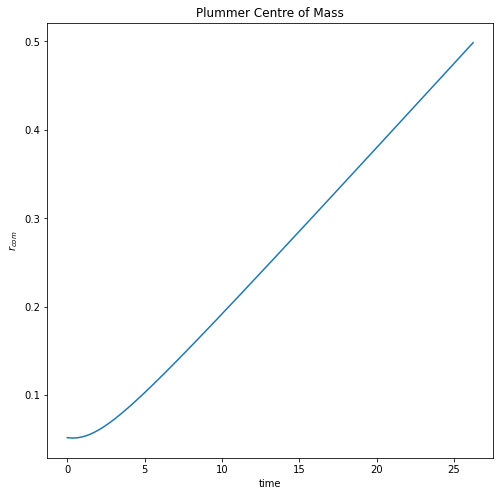

In [63]:
fig = plt.subplots(figsize=(8,8))

com_x_sim = np.sum(x_sim[:,:]*masses[:,:],axis=1)/(M_tot)#+M_perturber) # Plummer x COM
com_y_sim = np.sum(y_sim[:,:]*masses[:,:],axis=1)/(M_tot)#+M_perturber) # Plummer y COM
com_z_sim = np.sum(z_sim[:,:]*masses[:,:],axis=1)/(M_tot)#+M_perturber) # Plummer z COM

com_x_sim[0]=x[0]
com_y_sim[0]=y[0]
com_z_sim[0]=z[0]

com_r_sim = np.sqrt(com_x_sim[1:]**2 + com_y_sim[1:]**2 + com_z_sim[1:]**2) # Plummer r COM, distanza del centro di massa dal punto di origine

plt.plot(t_sim[:-1],com_r_sim)#/com_r_sim[0])
plt.xlabel('time')
plt.ylabel(r'$r_{com}$')#/r_{com,0}$')
plt.title('Plummer Centre of Mass')

Text(0, 0.5, 'z')

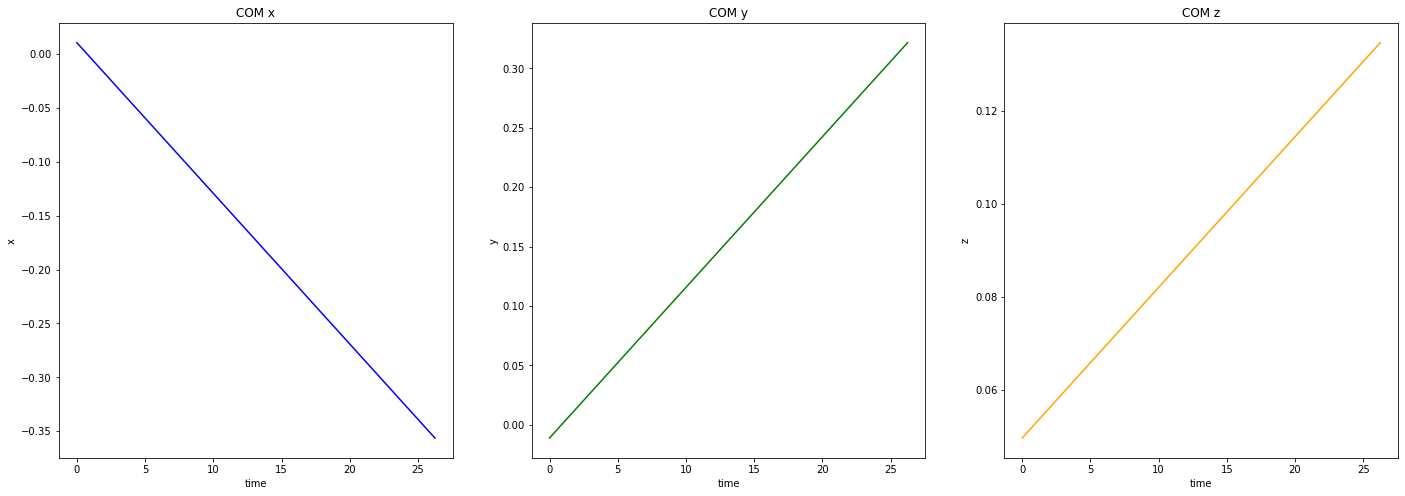

In [64]:
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(24,8))
ax[0].plot(t_sim[:-1],com_x_sim[1:],c='blue')
ax[0].set_title('COM x')
ax[0].set_xlabel('time')
ax[0].set_ylabel('x')
ax[1].plot(t_sim[:-1],com_y_sim[1:],c='green')
ax[1].set_title('COM y')
ax[1].set_xlabel('time')
ax[1].set_ylabel('y')
ax[2].plot(t_sim[:-1],com_z_sim[1:],c='orange')
ax[2].set_title('COM z')
ax[2].set_xlabel('time')
ax[2].set_ylabel('z')

In [65]:
x_sim_COM = np.empty([len(t_sim[:-1]),N])
y_sim_COM = np.empty([len(t_sim[:-1]),N])
z_sim_COM = np.empty([len(t_sim[:-1]),N])
r_sim_COM = np.empty([len(t_sim[:-1]),N])

for i in range(len(t_sim[:-1])):
    for j in range(N):
        x_sim_COM[i,j] = x_sim[i,j] - com_x_sim[i]
        y_sim_COM[i,j] = y_sim[i,j] - com_y_sim[i]
        z_sim_COM[i,j] = z_sim[i,j] - com_z_sim[i]

x_sim_COM[0]=x_sim[0]
y_sim_COM[0]=y_sim[0]
z_sim_COM[0]=z_sim[0]
r_sim_COM = np.sqrt(x_sim_COM**2+y_sim_COM**2+z_sim_COM**2)
r_sim_COM[0]=3   

In [80]:
r_sim_COM

array([[3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       [0.77509112, 5.44441082, 2.11294995, ..., 1.09313986, 1.39920845,
        0.58569288],
       [0.75943985, 5.46162546, 2.12192842, ..., 1.09535683, 1.38880874,
        0.55005267],
       ...,
       [0.2201066 , 6.65489277, 2.73058962, ..., 0.96997788, 1.64091562,
        1.20876504],
       [0.21341045, 6.64422196, 2.729403  , ..., 0.96713316, 1.65110393,
        1.20679523],
       [0.20661856, 6.63349031, 2.72800059, ..., 0.96434536, 1.66130634,
        1.20408532]])

Text(0.5, 1.0, 'Plummer Centre of Mass')

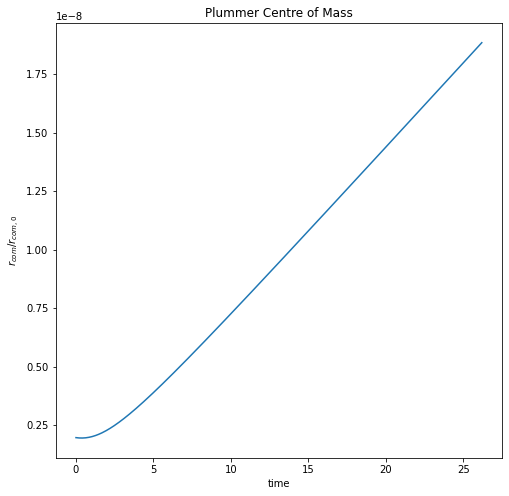

In [67]:
fig = plt.figure(figsize=(8,8))

com_x_check = np.sum(x_sim_COM*masses[:-1,:],axis=1)/(M_tot)#+M_perturber) # Plummer x COM
com_y_check = np.sum(y_sim_COM*masses[:-1,:],axis=1)/(M_tot)#+M_perturber) # Plummer y COM
com_z_check = np.sum(z_sim_COM*masses[:-1,:],axis=1)/(M_tot)#+M_perturber) # Plummer z COM

com_r_check = np.sqrt(com_x_check**2 + com_y_check**2 + com_z_check**2) # Plummer r COM
plt.plot(t_sim[:-2],com_r_check[1:])
plt.xlabel('time')
plt.ylabel(r'$r_{com}/r_{com,0}$')
plt.title('Plummer Centre of Mass')

Text(0, 0.5, 'z')

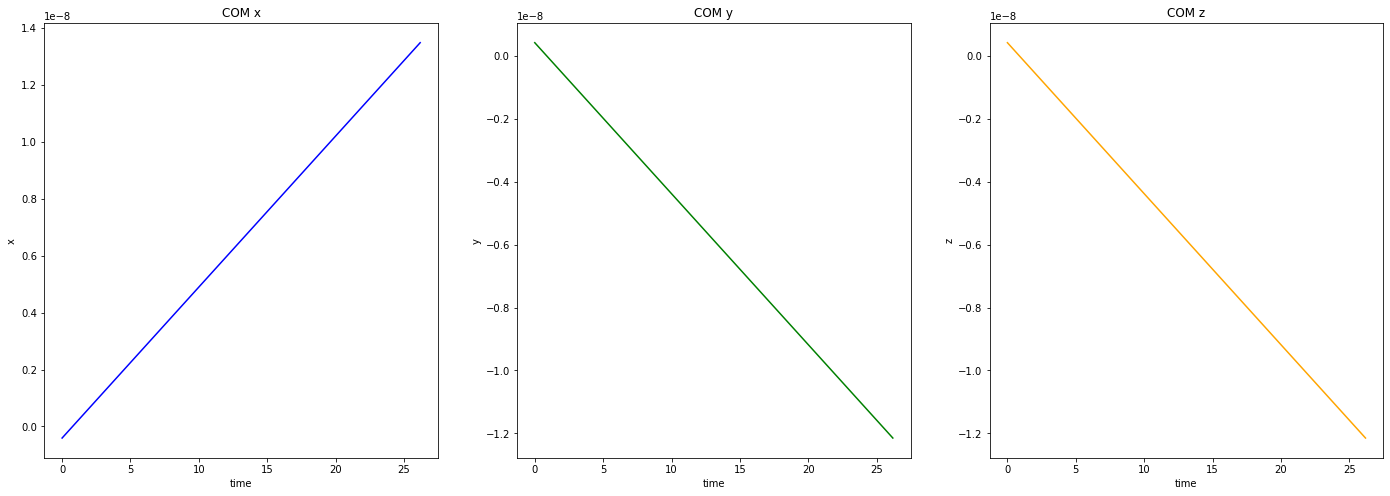

In [68]:
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(24,8))
ax[0].plot(t_sim[:-2],com_x_check[1:],c='blue')
ax[0].set_title('COM x')
ax[0].set_xlabel('time')
ax[0].set_ylabel('x')
ax[1].plot(t_sim[:-2],com_y_check[1:],c='green')
ax[1].set_title('COM y')
ax[1].set_xlabel('time')
ax[1].set_ylabel('y')
ax[2].plot(t_sim[:-2],com_y_check[1:],c='orange')
ax[2].set_title('COM z')
ax[2].set_xlabel('time')
ax[2].set_ylabel('z')

In [69]:
# compute the velocities of the Plummer sphere centre of mass
#La velocità è derivata come differenza delle coordinate del centro di massa rispetto al tempo.
#np.diff(com_x_sim, 1), np.diff(com_y_sim, 1), np.diff(com_z_sim, 1) calcolano la differenza finita delle coordinate del centro di massa tra istanti di tempo consecutivi.

Vx_com = np.diff(com_x_sim[1:],1)/np.diff(t_sim[:-1],1)
Vy_com = np.diff(com_y_sim[1:],1)/np.diff(t_sim[:-1],1)
Vz_com = np.diff(com_z_sim[1:],1)/np.diff(t_sim[:-1],1)
    
Vr_com = np.sqrt(Vx_com**2+Vy_com**2+Vz_com**2)

Text(0, 0.5, '$v_{z,com}$')

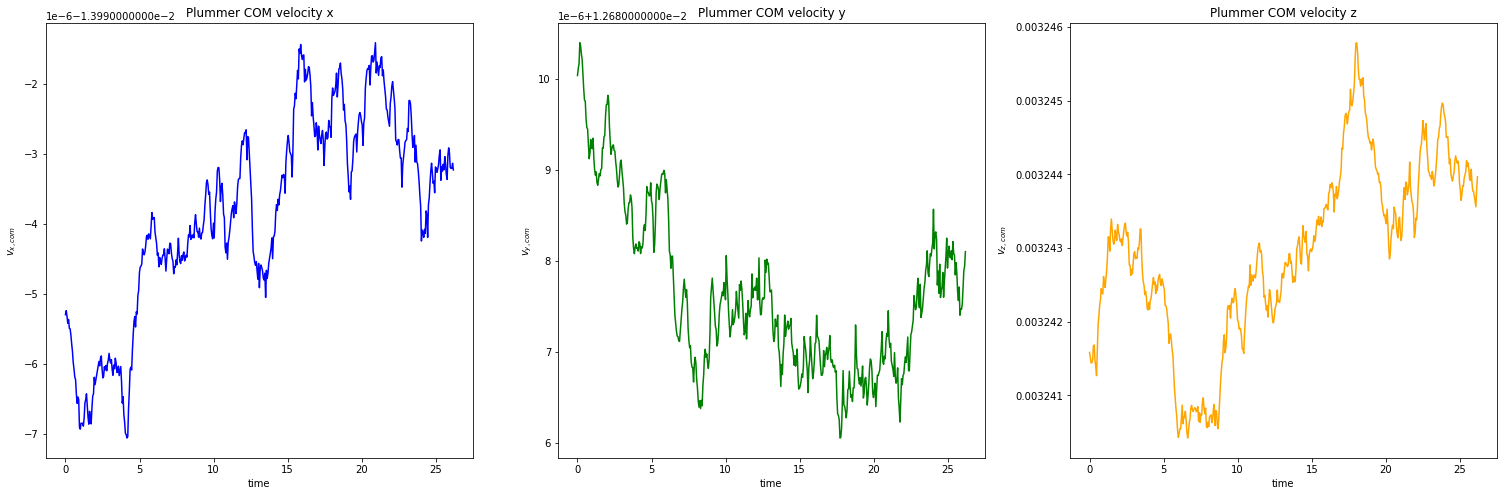

In [70]:
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(26,8))
ax[0].plot(t_sim[:-2],Vx_com,c='blue')
ax[0].set_title(r'Plummer COM velocity x')
ax[0].set_xlabel('time')
ax[0].set_ylabel('$v_{x,com}$')
ax[1].plot(t_sim[:-2],Vy_com,c='green')
ax[1].set_title(r'Plummer COM velocity y')
ax[1].set_xlabel('time')
ax[1].set_ylabel('$v_{y,com}$')
ax[2].plot(t_sim[:-2],Vz_com,c='orange')
ax[2].set_title(r'Plummer COM velocity z')
ax[2].set_xlabel('time')
ax[2].set_ylabel('$v_{z,com}$')

In [71]:
# move all the particles to the Plummer's centre of mass

Vx_sim_COM = np.empty([len(t_sim)-1,N+1])
Vy_sim_COM = np.empty([len(t_sim)-1,N+1])
Vz_sim_COM = np.empty([len(t_sim)-1,N+1])
Vr_sim_COM = np.empty([len(t_sim)-1,N+1])

for i in range(len(t_sim)-2):
    for j in range(N): 
        Vx_sim_COM[i,j] = Vx_sim[i,j] - Vx_com[i]
        Vy_sim_COM[i,j] = Vy_sim[i,j] - Vy_com[i]
        Vz_sim_COM[i,j] = Vz_sim[i,j] - Vz_com[i]
        #Vr_sim_COM[i,j] = np.sqrt(Vx_sim_COM[i,j]**2+Vy_sim_COM[i,j]**2+Vz_sim_COM[i,j]**2)






In [72]:
Vx_sim_COM[0,0]=v_x[0]
Vy_sim_COM[0,0]=v_y[0]
Vz_sim_COM[0,0]=v_z[0]
Vr_sim_COM = np.sqrt(Vx_sim_COM**2+Vy_sim_COM**2+Vz_sim_COM**2)

In [73]:
np.sqrt(2*0.3**2)

0.4242640687119285

In [74]:
np.sqrt(Vx_sim_COM[0,0]**2+Vy_sim_COM[0,0]**2+Vz_sim_COM[0,0]**2)

0.4242640687119285

In [75]:
Vr_sim_COM[0,0]

0.4242640687119285

Text(0.5, 1.0, 'Perturber radial evolution')

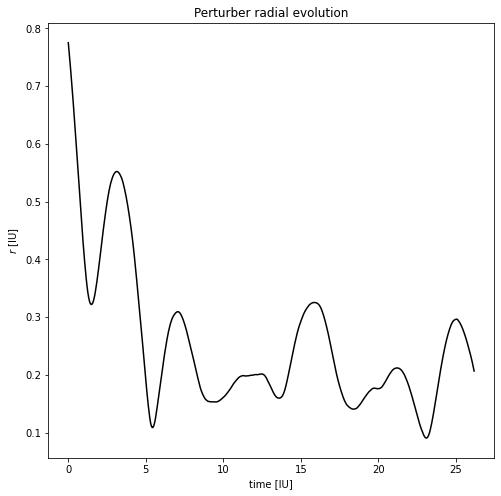

In [82]:
#Il codice traccia l'evoluzione radiale del perturbatore nel tempo. Questo grafico mostra come cambia la distanza del perturbatore dal centro di massa della sfera di Plummer nel tempo.

perturber_index = 0 #perturber_index è l'indice dell'ultima particella nell'array, cioè il perturbatore.

fig = plt.subplots(figsize=(8,8))

plt.plot(t_sim[:-2],r_sim_COM[1:,0],color='black')
#plt.plot(t_sim,com_r_sim)
plt.xlabel('time [IU]')
plt.ylabel(r'$r$ [IU]')
plt.title('Perturber radial evolution')

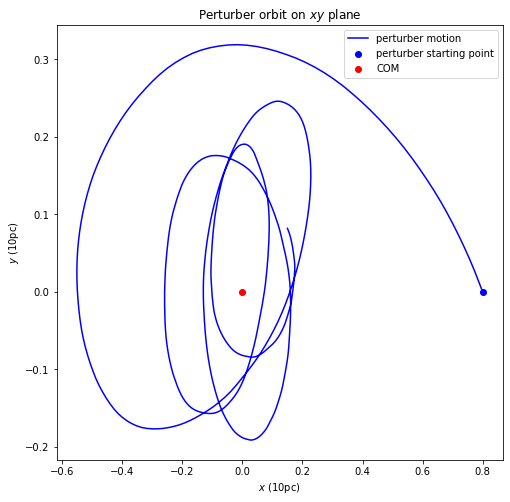

In [83]:
fig = plt.subplots(figsize=(8,8))

plt.plot(x_sim_COM[:,0],y_sim_COM[:,0],label='perturber motion',c='blue')
plt.scatter(x_sim_COM[0,0],y_sim_COM[0,0], label='perturber starting point',c='blue')
plt.scatter(com_x_check[1],com_y_check[1],label='COM',c='red')
plt.legend()
plt.title(r'Perturber orbit on $xy$ plane')
plt.xlabel(r'$x$ (10pc)')
plt.ylabel(r'$y$ (10pc)');

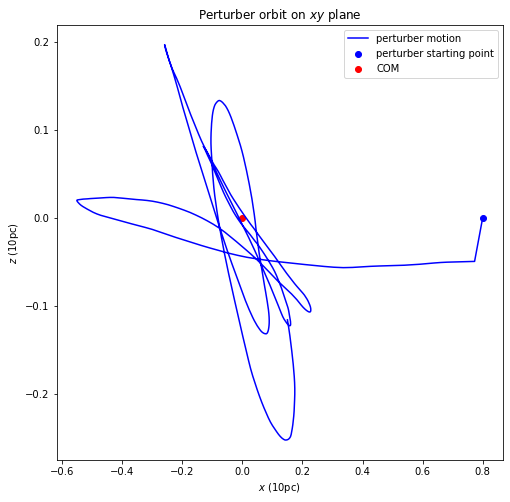

In [84]:
fig = plt.subplots(figsize=(8,8))

plt.plot(x_sim_COM[:,0],z_sim_COM[:,0],label='perturber motion',c='blue')
plt.scatter(x_sim_COM[0,0],z_sim_COM[0,0], label='perturber starting point',c='blue')
plt.scatter(com_x_check[1],com_z_check[1],label='COM',c='red')
plt.legend()
plt.title(r'Perturber orbit on $xy$ plane')
plt.xlabel(r'$x$ (10pc)')
plt.ylabel(r'$z$ (10pc)');

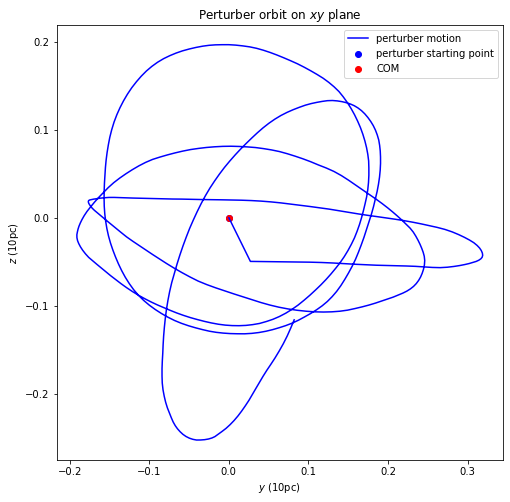

In [85]:
fig = plt.subplots(figsize=(8,8))

plt.plot(y_sim_COM[:,0],z_sim_COM[:,0],label='perturber motion',c='blue')
plt.scatter(y_sim_COM[0,0],z_sim_COM[0,0], label='perturber starting point',c='blue')
plt.scatter(com_y_check[1],com_z_check[1],label='COM',c='red')
plt.legend()
plt.title(r'Perturber orbit on $xy$ plane')
plt.xlabel(r'$y$ (10pc)')
plt.ylabel(r'$z$ (10pc)');

In [86]:
# build the position and velocity vectors 
# trasforma l'array in modo che ogni riga corrisponda a un istante di tempo e ogni colonna a una dimensione spaziale 

pos_vector_Plummer = np.array([x_sim_COM[1:,1:],y_sim_COM[1:,1:],z_sim_COM[1:,1:]]).T # transpose for calculation reasons
vel_vector_Plummer = np.array([Vx_sim_COM[1:,1:],Vy_sim_COM[1:,1:],Vz_sim_COM[1:,1:]]).T

pos_vector_pert = np.array([x_sim_COM[:,0],y_sim_COM[:,0],z_sim_COM[:,0]]).T
vel_vector_pert = np.array([Vx_sim_COM[:,0],Vy_sim_COM[:,0],Vz_sim_COM[:,0]]).T

In [87]:
pos_vector_Plummer.shape

(3999, 499, 3)

In [88]:
# angular momentum of the Plummer sphere
L_Plummer = np.empty([len(t_sim[:-1])-1, N-1, 3])

for i in tqdm(range(1, len(t_sim[:-1])-1)):
    for j in range(1, N-1):
        L_Plummer[i,j] = masses[i,j]*np.cross(pos_vector_Plummer[j,i],vel_vector_Plummer[j,i])

100%|█████████████████████████████████████████| 498/498 [01:14<00:00,  6.68it/s]


In [89]:
L_Plummer.shape

(499, 3999, 3)

In [90]:
Lx_Plummer = np.zeros(len(t_sim[:-1])-1)
Ly_Plummer = np.zeros(len(t_sim[:-1])-1)
Lz_Plummer = np.zeros(len(t_sim[:-1])-1)

In [91]:
for i in range(len(t_sim[:-1])-1):
    Lx_Plummer[i] = np.sum(L_Plummer[i,:,0])
    Ly_Plummer[i] = np.sum(L_Plummer[i,:,1])
    Lz_Plummer[i] = np.sum(L_Plummer[i,:,2])
    
L_tot_Plummer = np.sqrt(Lx_Plummer**2+Ly_Plummer**2+Lz_Plummer**2)

In [92]:
L_Plummer[0,:,0].shape

(3999,)

In [93]:
pos_vector_pert.shape

(500, 3)

In [94]:
L_perturber = np.empty([len(t_sim[:-1])-1, 3])

for i in range(len(t_sim[:-1])-1):
    L_perturber[i] = M_BH*np.cross(pos_vector_pert[i],vel_vector_pert[i])

In [95]:
Lx_perturber = L_perturber[:,0]
Ly_perturber = L_perturber[:,1]
Lz_perturber = L_perturber[:,2]
    
L_tot_perturber = np.sqrt(Lx_perturber**2 + Ly_perturber**2 + Lz_perturber**2)

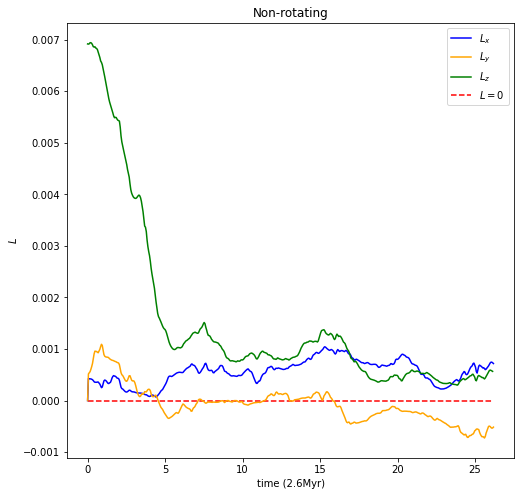

In [96]:
fig = plt.figure(figsize=(8,8))

plt.plot(t_sim[:-2],Lx_perturber, label=r'$L_x$',color='blue')
plt.plot(t_sim[:-2],Ly_perturber, label=r'$L_y$',color='orange')
plt.plot(t_sim[:-3],Lz_perturber[1:], label=r'$L_z$',color='green') 
plt.hlines(0,min(t_sim[:-2]),max(t_sim[:-2]),color='red',label=r'$L=0$',linestyle='--')

plt.title('Non-rotating')
plt.xlabel('time (2.6Myr)')
plt.ylabel(r'$L$')

plt.legend()

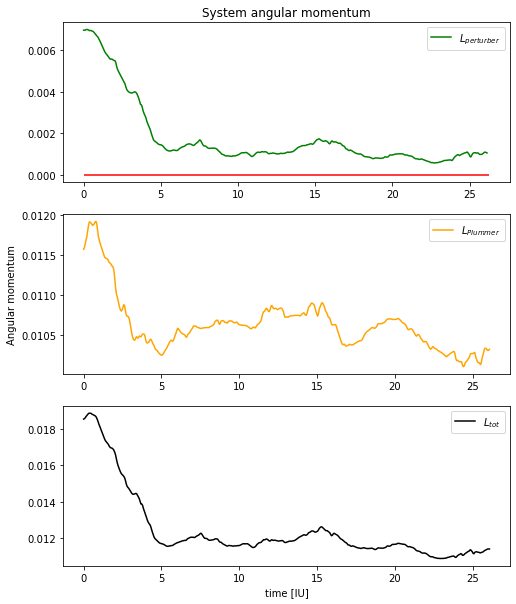

In [97]:
L_tot = L_tot_perturber + L_tot_Plummer

fig,ax = plt.subplots(nrows=3,ncols=1,figsize=(8,10))

ax[0].set_title('System angular momentum')
ax[0].plot(t_sim[:-3],L_tot_perturber[1:],color='green',label=r'$L_{perturber}$')
ax[0].hlines(0,min(t_sim),max(t_sim),color='red')
ax[0].legend()
ax[1].plot(t_sim[:-4],L_tot_Plummer[1:-1],color='orange',label=r'$L_{Plummer}$')
ax[1].set_ylabel('Angular momentum')
ax[1].legend()
ax[2].plot(t_sim[:-4],L_tot[1:-1],color='black',label=r'$L_{tot}$')
ax[2].legend()

plt.xlabel('time [IU]')

plt.show()

NameError: name 'time' is not defined

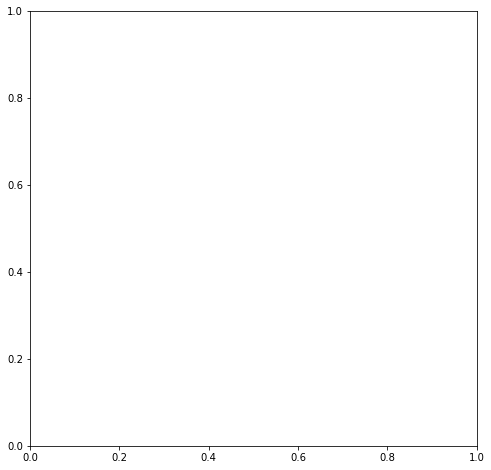

In [98]:
fig = plt.subplots(figsize=(8,8))

plt.plot(time,T,label=r'T')
plt.plot(time,U,label=r'U')

E_sys = T+U

plt.plot(time,E_sys,label=r'$E_{tot}$')
plt.legend()
plt.title('Energy conservation')
plt.xlabel('Time')
plt.ylabel('Energy')

In [239]:
T

2.6289708396695617

In [240]:
U

NameError: name 'U' is not defined